In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.signal import find_peaks
from sklearn.metrics import mutual_info_score
from matplotlib.pyplot import figure
import matplotlib

matplotlib.rc('figure', figsize=(18, 4))

In [63]:
data = pd.read_csv('TrozoG.txt', delimiter='\t', header=None, skiprows = range(3), decimal = ",", index_col = False)

In [64]:
print(len(data))
data.drop(columns=[3], inplace=True)
data.columns = ['LP','VD','TiempoGABA']
data = data.apply(pd.to_numeric)
# data['Time'] = data.index*0.1
data['Time'] = data.index
print(data.head())

# Sample interval = 0,100000
# Number of channels = 3
# Number of samples per channel = 16384000

16384000
         LP        VD  TiempoGABA  Time
0 -0.006104  0.064697    0.120239     0
1 -0.004272  0.075989    0.126343     1
2 -0.003357  0.087280    0.125427     2
3 -0.005188  0.092468    0.123596     3
4 -0.007324  0.093384    0.118713     4


In [65]:
data.dropna(axis=0, how='any',inplace=True)
data.isnull().sum()

LP            0
VD            0
TiempoGABA    0
Time          0
dtype: int64

In [66]:
data.describe()

,LP,VD,TiempoGABA,Time
count,1.638400e+07,1.638400e+07,1.638400e+07,1.638400e+07
mean,1.782227e-11,4.330900e-02,1.361662e-01,8.192000e+06
std,8.109792e-02,3.337760e-02,2.849763e-01,4.729654e+06
min,-6.420900e-01,-3.088380e-01,-5.462600e-02,0.000000e+00
25%,-2.624500e-02,3.326400e-02,1.141360e-01,4.096000e+06
50%,0.000000e+00,4.303000e-02,1.199340e-01,8.192000e+06
75%,2.441400e-02,5.310100e-02,1.260380e-01,1.228800e+07
max,9.265140e-01,5.520630e-01,5.220642e+00,1.638400e+07


In [67]:
lp_mean = np.mean(data.LP)
lp_sd = np.std(data.LP)
low_lp, high_lp = lp_mean-4*lp_sd, lp_mean+4*lp_sd
print('LP:\n\tMean: %f\n\tSD: %f\n\tLow: %f\n\tHigh: %f'%(lp_mean,lp_sd,low_lp,high_lp))

vd_mean = np.mean(data.VD)
vd_sd = np.std(data.VD)
low_vd, high_vd = vd_mean-4*vd_sd, vd_mean+4*vd_sd
print('VD:\n\tMean: %f\n\tSD: %f\n\tLow: %f\n\tHigh: %f'%(vd_mean,vd_sd,low_vd,high_vd))

LP:
	Mean: 0.000000
	SD: 0.081098
	Low: -0.324392
	High: 0.324392
VD:
	Mean: 0.043309
	SD: 0.033378
	Low: -0.090201
	High: 0.176819


Text(0.18681939032474554, 50000.0, '0.18')

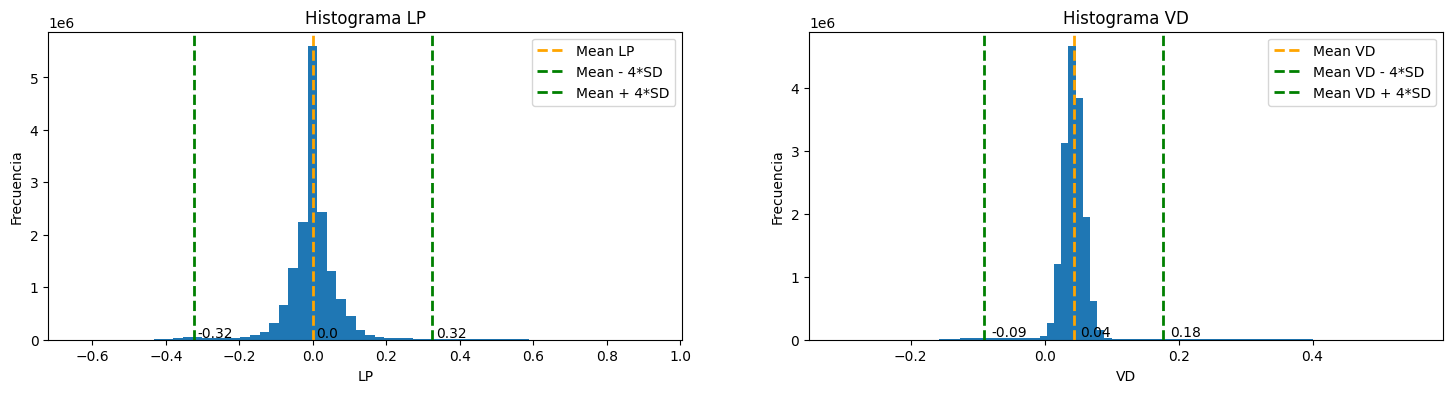

In [68]:
plt.subplot(1,2,1)
plt.hist(data.LP, bins=60)
plt.axvline(x = lp_mean, color='orange', linestyle='--', linewidth=2, label = 'Mean LP')
plt.axvline(x = low_lp, color='g', linestyle='--', linewidth=2, label = 'Mean - 4*SD')
plt.axvline(x = high_lp, color='g', linestyle='--', linewidth=2, label = 'Mean + 4*SD')
plt.title('Histograma LP')
plt.xlabel('LP')
plt.ylabel('Frecuencia')
plt.legend()
plt.annotate(str(round(lp_mean,2)),(lp_mean + 0.01,0.05e6))
plt.annotate(str(round(low_lp,2)),(low_lp + 0.01,0.05e6))
plt.annotate(str(round(high_lp,2)),(high_lp + 0.01,0.05e6))

plt.subplot(1,2,2)
plt.hist(data.VD, bins=80)
plt.axvline(x = vd_mean, color='orange', linestyle='--', linewidth=2, label = 'Mean VD')
plt.axvline(x = low_vd, color='g', linestyle='--', linewidth=2, label = 'Mean VD - 4*SD')
plt.axvline(x = high_vd, color='g', linestyle='--', linewidth=2, label = 'Mean VD + 4*SD')
plt.title('Histograma VD')
plt.xlabel('VD')
plt.ylabel('Frecuencia')
plt.legend()
plt.annotate(str(round(vd_mean,2)),(vd_mean + 0.01,+0.05e6))
plt.annotate(str(round(low_vd,2)),(low_vd + 0.01,+0.05e6))
plt.annotate(str(round(high_vd,2)),(high_vd + 0.01,+0.05e6))

In [69]:
spikes_lp = find_peaks(data['LP'])[0]
spikes_vd = find_peaks(data['VD'])[0]

lp_sp_data = pd.DataFrame(data = {'Time':spikes_lp,'ValueLP':data['LP'][spikes_lp],'IsSpikeLP' : 1})
lp_sp_data = lp_sp_data[lp_sp_data['ValueLP'] >= high_lp]

vd_sp_data = pd.DataFrame(data = {'Time':spikes_vd,'ValueVD':data['VD'][spikes_vd],'IsSpikeVD' : 1})
vd_sp_data = vd_sp_data[vd_sp_data['ValueVD'] >= high_vd]


In [70]:
data = pd.merge(data, lp_sp_data, on = 'Time', how='left')
data = pd.merge(data, vd_sp_data, on = 'Time', how='left')
data['IsSpikeLP'].fillna(0, inplace=True)
data['IsSpikeVD'].fillna(0, inplace=True)


In [71]:
data.head()

,LP,VD,TiempoGABA,Time,ValueLP,IsSpikeLP,ValueVD,IsSpikeVD
0,-0.006104,0.064697,0.120239,0,NaN,0.0,NaN,0.0
1,-0.004272,0.075989,0.126343,1,NaN,0.0,NaN,0.0
2,-0.003357,0.087280,0.125427,2,NaN,0.0,NaN,0.0
3,-0.005188,0.092468,0.123596,3,NaN,0.0,NaN,0.0
4,-0.007324,0.093384,0.118713,4,NaN,0.0,NaN,0.0


C:\Users\marlo\AppData\Local\Temp\ipykernel_4992\3813888968.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['breaks'] = np.repeat(breaks,break_size)[0:data_end-data_init]


Text(0, -30, 'Tamaño de ventana: 100\nMean+4*sd: 0.1768\nPalabra: 1 bit')

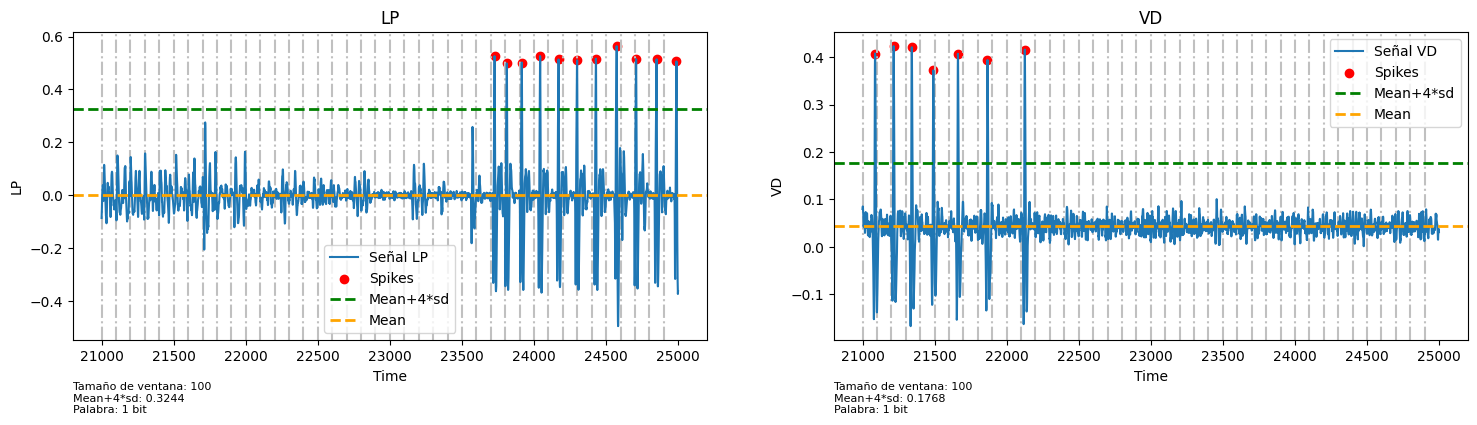

In [72]:
break_size = 100
data_init = 21000
data_end = 25000

data2 = data
data2 = data2.iloc[data_init:data_end]
breaks = np.arange(data_init,data_end,break_size)
data2['breaks'] = np.repeat(breaks,break_size)[0:data_end-data_init]

plt.subplot(1,2,1)
for i in breaks[breaks<=data_end]:
    plt.axvline(x=i, color = 'silver', linestyle = '-.')

plt.plot(data2.Time, data2.LP, label = 'Señal LP')
plt.scatter(data2.Time[data2['IsSpikeLP'] == 1], data2.ValueLP[data2['IsSpikeLP'] == 1], color = 'r', label = 'Spikes')
plt.axhline(y = high_lp, color='g', linestyle='--', linewidth=2, label = 'Mean+4*sd')
plt.axhline(y = lp_mean, color='orange', linestyle='--', linewidth=2, label = 'Mean')
plt.title('LP')
plt.xlabel('Time')
plt.ylabel('LP')
plt.legend()
plt.annotate('Tamaño de ventana: '+ str(break_size) + '\nMean+4*sd: '+ str(round(high_lp,4)) + '\nPalabra: 1 bit', (0,0), (0,-30), fontsize=8, 
             xycoords='axes fraction', textcoords='offset points', va='top')

plt.subplot(1, 2, 2)
for i in breaks[breaks<=data_end]:
    plt.axvline(x=i, color = 'silver', linestyle = '-.')
plt.plot(data2.Time, data2.VD, label = 'Señal VD')
plt.scatter(data2.Time[data2['IsSpikeVD'] == 1], data2.ValueVD[data2['IsSpikeVD'] == 1], color = 'r', label = 'Spikes')
plt.axhline(y = high_vd, color='g', linestyle='--', linewidth=2, label =  'Mean+4*sd')
plt.axhline(y = vd_mean, color='orange', linestyle='--', linewidth=2, label = 'Mean')
plt.title('VD')
plt.xlabel('Time')
plt.ylabel('VD')
plt.legend()
plt.annotate('Tamaño de ventana: '+ str(break_size) + '\nMean+4*sd: '+ str(round(high_vd,4)) + '\nPalabra: 1 bit', (0,0), (0,-30), fontsize=8, 
             xycoords='axes fraction', textcoords='offset points', va='top')

In [73]:
for p in range(1,9):
    palabra = p
    breaks = np.arange(0,len(data),palabra)
    data.loc[:,'W'+str(p)] = np.repeat(breaks,palabra)[0:len(data)]

data.head()

,LP,VD,TiempoGABA,Time,ValueLP,IsSpikeLP,ValueVD,IsSpikeVD,W1,W2,W3,W4,W5,W6,W7,W8
0,-0.006104,0.064697,0.120239,0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,0
1,-0.004272,0.075989,0.126343,1,NaN,0.0,NaN,0.0,1,0,0,0,0,0,0,0
2,-0.003357,0.087280,0.125427,2,NaN,0.0,NaN,0.0,2,2,0,0,0,0,0,0
3,-0.005188,0.092468,0.123596,3,NaN,0.0,NaN,0.0,3,2,3,0,0,0,0,0
4,-0.007324,0.093384,0.118713,4,NaN,0.0,NaN,0.0,4,4,3,4,0,0,0,0


In [74]:
data_palabras = list()

for i in data.columns[8:len(data.columns)]:
    d = data.groupby(i)[['IsSpikeLP','IsSpikeVD']].agg('sum').reset_index()
    d['IsSpikeLP'] = d['IsSpikeLP'] > 0
    d['IsSpikeVD'] = d['IsSpikeVD'] > 0
    data_palabras.append(d)

    print('Tamaño de Palabra: %s\nDimensión dataframe: %s'%(str(i),str(d.shape)))
    print(d.head(3))
    print('\n')

Tamaño de Palabra: W1
Dimensión dataframe: (16384000, 3)
   W1  IsSpikeLP  IsSpikeVD
0   0      False      False
1   1      False      False
2   2      False      False


Tamaño de Palabra: W2
Dimensión dataframe: (8192000, 3)
   W2  IsSpikeLP  IsSpikeVD
0   0      False      False
1   2      False      False
2   4      False      False


Tamaño de Palabra: W3
Dimensión dataframe: (5461334, 3)
   W3  IsSpikeLP  IsSpikeVD
0   0      False      False
1   3      False      False
2   6      False      False


Tamaño de Palabra: W4
Dimensión dataframe: (4096000, 3)
   W4  IsSpikeLP  IsSpikeVD
0   0      False      False
1   4      False      False
2   8      False      False


Tamaño de Palabra: W5
Dimensión dataframe: (3276800, 3)
   W5  IsSpikeLP  IsSpikeVD
0   0      False      False
1   5      False      False
2  10      False      False


Tamaño de Palabra: W6
Dimensión dataframe: (2730667, 3)
   W6  IsSpikeLP  IsSpikeVD
0   0      False      False
1   6      False      False
2  12    

In [75]:
int(data_palabras[0].columns[0][1])

1

In [76]:
window_sizes_w = np.arange(10,600,10)
df_w_metrics = {}

for df_w in data_palabras:
    df_w_MI = []
    df_w_MI_norm = []
    df_w_E_lp = []
    df_w_E_vd = []
    df_entropy_lp_a_vd = []
    df_entropy_vd_a_lp = []

    for win_size in window_sizes_w:
        breaks = np.arange(0,len(df_w),win_size)
        d = df_w
        d.loc[:,'breaks'] = np.repeat(breaks,win_size)[0:len(d)]
        d = d.groupby('breaks')[['IsSpikeLP','IsSpikeVD']].agg('sum').reset_index()
        d['ErrorsLP'] = d['IsSpikeLP'] > 1
        d['ErrorsVD'] = d['IsSpikeVD'] > 1
        df_w_E_lp.append(sum(d['ErrorsLP'])/len(d)*100)
        df_w_E_vd.append(sum(d['ErrorsVD'])/len(d)*100)

        MI = mutual_info_score(d['IsSpikeLP'], d['IsSpikeVD'])
        MI_norm = mutual_info_score(d['IsSpikeLP'], d['IsSpikeVD'])/(win_size*int(df_w.columns[0][1]))
        Slp = stats.entropy(d['IsSpikeLP'])
        Svd = stats.entropy(d['IsSpikeVD'])

        df_w_MI.append(MI) 
        df_w_MI_norm.append(MI_norm)   
        df_entropy_lp_a_vd.append(MI/Svd)
        df_entropy_vd_a_lp.append(MI/Slp)

    df_w_m = pd.DataFrame({'WindSize':window_sizes_w, 'ErrorLP':df_w_E_lp, 'ErrorVD':df_w_E_vd, 
                           'MI':df_w_MI, 'MI_norm':df_w_MI_norm, 'Slp_vd':df_entropy_lp_a_vd,'Svd_lp':df_entropy_vd_a_lp})
    df_w_metrics[df_w.columns[0]]  = df_w_m




In [77]:
df_w_metrics['W1']

,WindSize,ErrorLP,ErrorVD,MI,MI_norm,Slp_vd,Svd_lp
0,10,0.000305,0.000000,0.000108,0.000011,0.000011,0.000011
1,20,0.000977,0.000122,0.000456,0.000023,0.000047,0.000045
2,30,0.004395,0.000183,0.001048,0.000035,0.000108,0.000103
3,40,0.015381,0.000244,0.001853,0.000046,0.000192,0.000181
4,50,0.025024,0.000305,0.002961,0.000059,0.000307,0.000290
5,60,0.043213,0.000366,0.004256,0.000071,0.000441,0.000417
6,70,0.062805,0.001282,0.005850,0.000084,0.000606,0.000573
7,80,0.079590,0.014160,0.007615,0.000095,0.000789,0.000746
8,90,0.093384,0.044494,0.009908,0.000110,0.001027,0.000971
9,100,0.133057,0.109253,0.012341,0.000123,0.001280,0.001210


In [78]:
import pickle

with open("trozo_G_metrics", "wb") as fp:   #Pickling
    pickle.dump(df_w_metrics, fp)

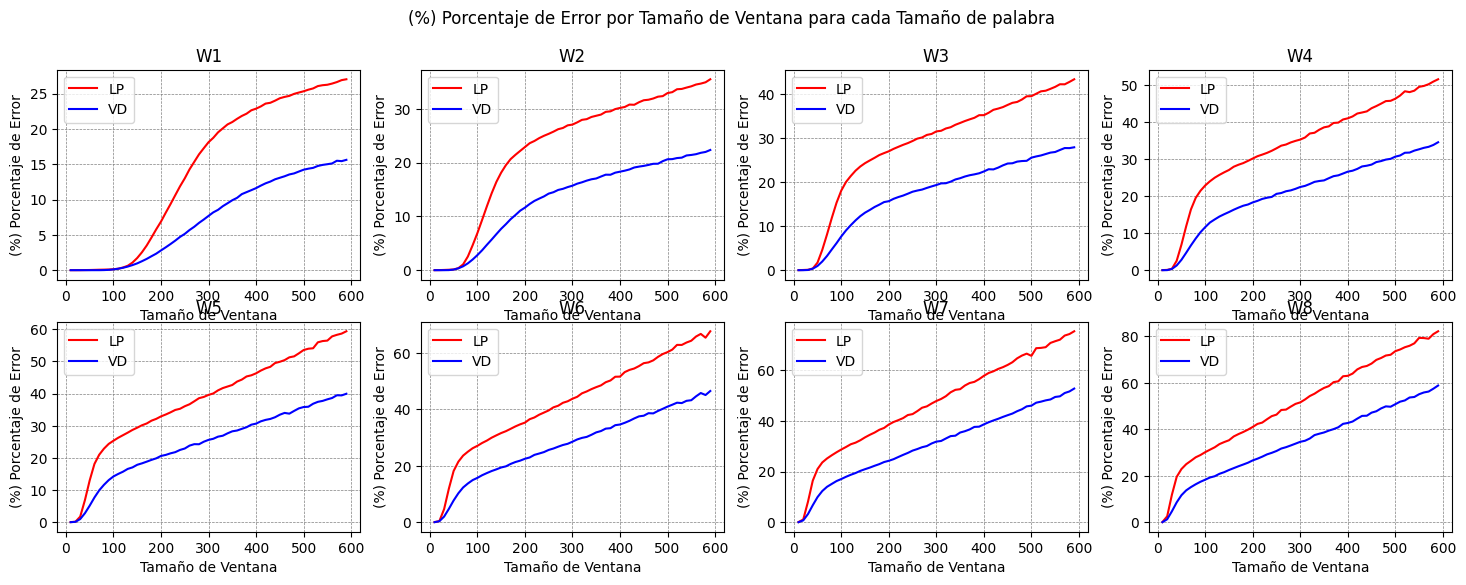

In [79]:
n_rows = 2
n_cols = 4
keys = [key for key in df_w_metrics]

fig, axs = plt.subplots(n_rows, n_cols)
n_plots = 0
fig.suptitle('(%) Porcentaje de Error por Tamaño de Ventana para cada Tamaño de palabra')
for r in range(n_rows):
    for c in range(n_cols):
        df = df_w_metrics[keys[n_plots]]

        axs[r, c].plot(df['WindSize'], df['ErrorLP'],color = 'red', label = 'LP')
        axs[r, c].plot(df['WindSize'], df['ErrorVD'],color = 'blue', label = 'VD')
        axs[r, c].set_title(keys[n_plots])
        axs[r, c].grid(color = 'gray', linestyle = '--', linewidth = 0.5)
        axs[r, c].legend()


        n_plots+=1

for ax in axs.flat:
    ax.set(xlabel='Tamaño de Ventana', ylabel='(%) Porcentaje de Error')

# for ax in axs.flat:
#     ax.label_outer()

fig.set_size_inches(18, 6)


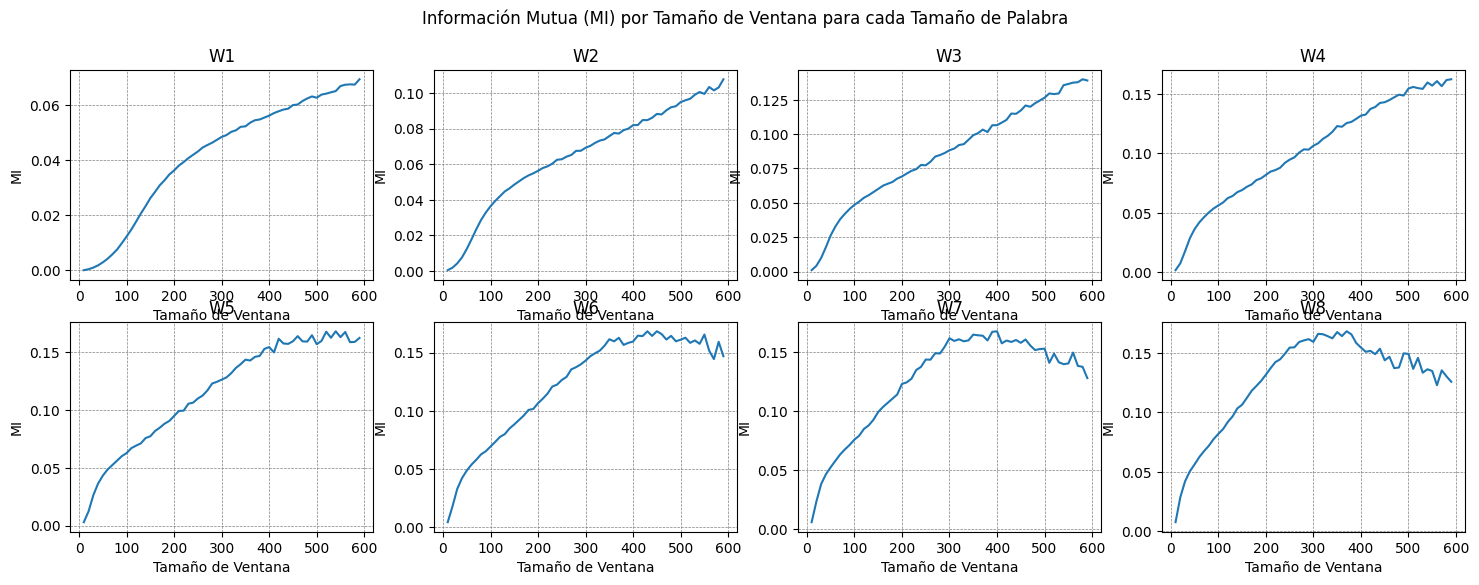

In [80]:
n_cols = 4
keys = [key for key in df_w_metrics]

fig, axs = plt.subplots(n_rows, n_cols)
n_plots = 0
fig.suptitle('Información Mutua (MI) por Tamaño de Ventana para cada Tamaño de Palabra')
for r in range(n_rows):
    for c in range(n_cols):
        df = df_w_metrics[keys[n_plots]]

        axs[r, c].plot(df['WindSize'], df['MI'])
        axs[r, c].set_title(keys[n_plots])
        axs[r, c].grid(color = 'gray', linestyle = '--', linewidth = 0.5)


        n_plots+=1

for ax in axs.flat:
    ax.set(xlabel='Tamaño de Ventana', ylabel='MI')

# for ax in axs.flat:
#     ax.label_outer()

fig.set_size_inches(18, 6)

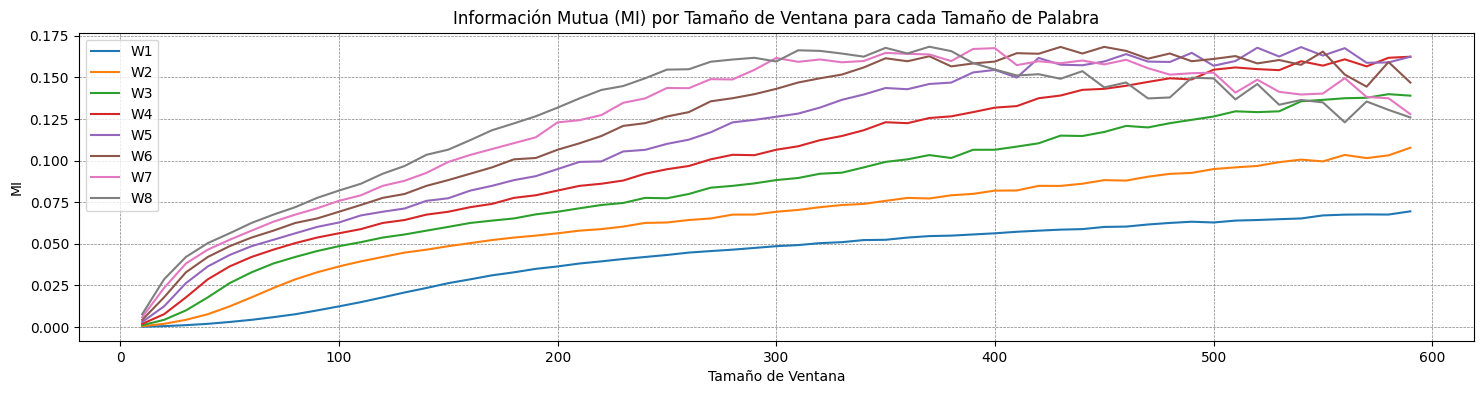

In [81]:
for w in [key for key in df_w_metrics]:
    df = df_w_metrics[w]
    plt.plot(df['WindSize'], df['MI'], label = w)

plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.title('Información Mutua (MI) por Tamaño de Ventana para cada Tamaño de Palabra')
plt.xlabel('Tamaño de Ventana')
plt.ylabel('MI')
plt.legend()

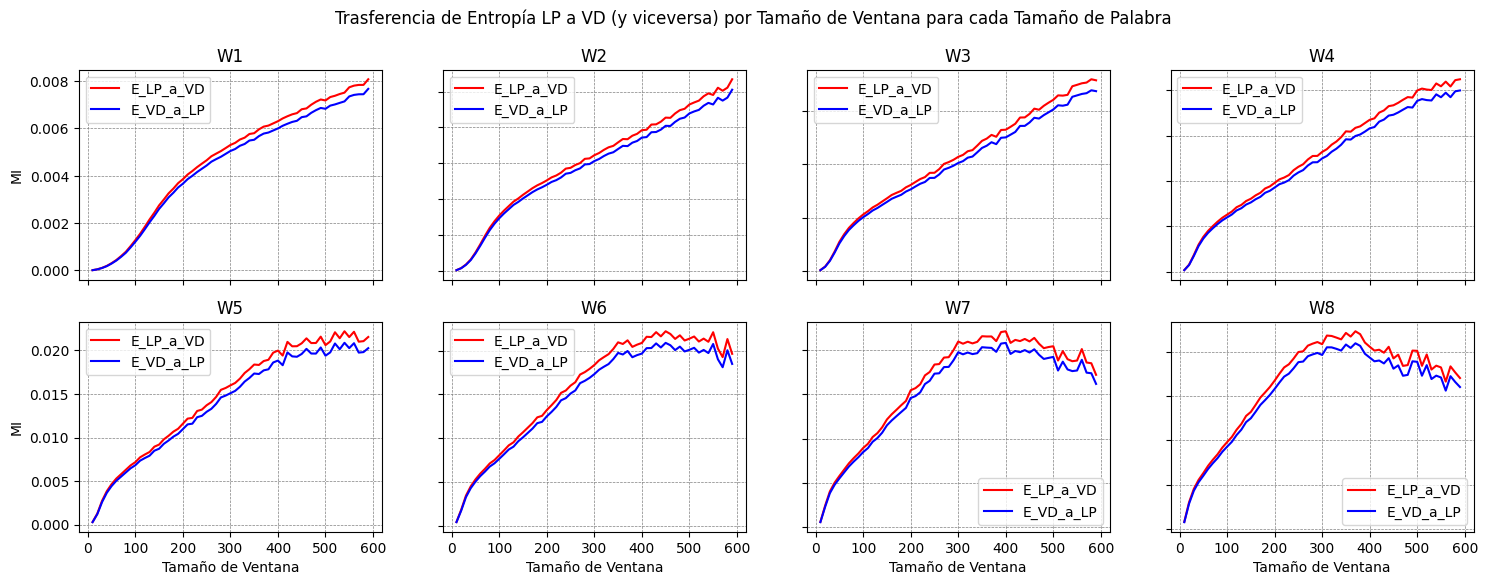

In [82]:
n_cols = 4
keys = [key for key in df_w_metrics]

fig, axs = plt.subplots(n_rows, n_cols)
n_plots = 0
fig.suptitle('Trasferencia de Entropía LP a VD (y viceversa) por Tamaño de Ventana para cada Tamaño de Palabra')
for r in range(n_rows):
    for c in range(n_cols):
        df = df_w_metrics[keys[n_plots]]

        axs[r, c].plot(df['WindSize'], df['Slp_vd'],color = 'red', label = 'E_LP_a_VD')
        axs[r, c].plot(df['WindSize'], df['Svd_lp'],color = 'blue', label = 'E_VD_a_LP')
        axs[r, c].set_title(keys[n_plots])
        axs[r, c].grid(color = 'gray', linestyle = '--', linewidth = 0.5)
        axs[r, c].legend()


        n_plots+=1

for ax in axs.flat:
    ax.set(xlabel='Tamaño de Ventana', ylabel='MI')

for ax in axs.flat:
    ax.label_outer()

fig.set_size_inches(18, 6)